In [2]:
#| default_exp core

In [3]:
#| hide
%load_ext autoreload
%autoreload 2

# <span style="color:DarkOrange"> Core </span>
> NeuralForecast contains two main components, PyTorch implementations deep learning predictive models, as well as parallelization and distributed computation utilities. The first component comprises low-level PyTorch model estimator classes like `models.NBEATS` and `models.RNN`. The second component is a high-level `core.NeuralForecast` wrapper class that operates with sets of time series data stored in pandas DataFrames.

In [4]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [5]:
#| export
from typing import Any, List, Optional

import numpy as np
import pandas as pd

from neuralforecast.tsdataset import TimeSeriesDataset

In [6]:
#| exporti
def _cv_dates(last_dates, freq, h, test_size, step_size=1):
    #assuming step_size = 1
    if (test_size - h) % step_size:
        raise Exception('`test_size - h` should be module `step_size`')
    n_windows = int((test_size - h) / step_size) + 1
    if len(np.unique(last_dates)) == 1:
        if issubclass(last_dates.dtype.type, np.integer):
            total_dates = np.arange(last_dates[0] - test_size + 1, last_dates[0] + 1)
            out = np.empty((h * n_windows, 2), dtype=last_dates.dtype)
            freq = 1
        else:
            total_dates = pd.date_range(end=last_dates[0], periods=test_size, freq=freq)
            out = np.empty((h * n_windows, 2), dtype='datetime64[s]')
        for i_window, cutoff in enumerate(range(-test_size, -h + 1, step_size), start=0):
            end_cutoff = cutoff + h
            out[h * i_window : h * (i_window + 1), 0] = total_dates[cutoff:] if end_cutoff == 0 else total_dates[cutoff:end_cutoff]
            out[h * i_window : h * (i_window + 1), 1] = np.tile(total_dates[cutoff] - freq, h)
        dates = pd.DataFrame(np.tile(out, (len(last_dates), 1)), columns=['ds', 'cutoff'])
    else:
        dates = pd.concat([_cv_dates(np.array([ld]), freq, h, test_size, step_size) for ld in last_dates])
        dates = dates.reset_index(drop=True)
    return dates

In [7]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [47, 48, 49],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [46] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5))

In [8]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5, step_size=2))

In [9]:
#| hide
for e_e in [True, False]:
    n_series = 2
    ga, indices, dates, ds = TimeSeriesDataset.from_df(generate_series(n_series, equal_ends=e_e), sort_df=True)
    freq = pd.tseries.frequencies.to_offset('D')
    horizon = 3
    test_size = 5
    df_dates = _cv_dates(last_dates=dates, freq=freq, h=horizon, test_size=test_size)
    test_eq(len(df_dates), n_series * horizon * (test_size - horizon + 1)) 

In [10]:
#| export
class NeuralForecast:
    
    def __init__(self, 
                 models: List[Any],
                 freq: str):
        """
        The `core.StatsForecast` class allows you to efficiently fit multiple `NeuralForecast` models 
        for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
        and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
        time series variable.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>
        `models`: List[typing.Any], instantiated `neuralforecast.models` see [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
        `freq`: str, frequency of the data, [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).<br>
        `trainers`: List[typing.Any], optional list of instantiated pytorch lightning trainers.<br>
        """
        assert all(model.h == models[0].h for model in models), 'All models should have the same horizon'

        self.h = models[0].h
        self.models = models
        self.freq = pd.tseries.frequencies.to_offset(freq)

    def _prepare_fit(self, df, sort_df):
        #TODO: uids, last_dates and ds should be properties of the dataset class. See github issue.
        self.dataset, self.uids, self.last_dates, self.ds = TimeSeriesDataset.from_df(df=df, sort_df=sort_df)
        self.sort_df = sort_df

    def fit(self,
            df: Optional[pd.DataFrame],
            val_size: Optional[int] = 0,
            sort_df: bool = True):
        """Fit the core.NeuralForecast.

        Fit `models` to a large set of time series from DataFrame `df`.
        and store fitted models for later inspection.

        **Parameters:**<br>
        `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
        `val_size`: int, size of validation set.<br>
        `sort_df`: bool, sort df before fitting.

        **Returns:**<br>
        `self`: Returns with stored `NeuralForecast` fitted `models`.
        """
        self._prepare_fit(df, sort_df)
        #train + validation
        for model in self.models:
            model.fit(self.dataset, val_size=val_size)
        #train with the full dataset

    def _make_future_df(self, h: int):
        if issubclass(self.last_dates.dtype.type, np.integer):
            last_date_f = lambda x: np.arange(x + 1, x + 1 + h, dtype=self.last_dates.dtype)
        else:
            last_date_f = lambda x: pd.date_range(x + self.freq, periods=h, freq=self.freq)
        if len(np.unique(self.last_dates)) == 1:
            dates = np.tile(last_date_f(self.last_dates[0]), len(self.dataset))
        else:
            dates = np.hstack([last_date_f(last_date)
                               for last_date in self.last_dates])
        idx = pd.Index(np.repeat(self.uids, h), name='unique_id')
        df = pd.DataFrame({'ds': dates}, index=idx)
        return df

    def predict(self, futr_df: Optional[pd.DataFrame] = None, **data_kwargs):
        """Predict with core.NeuralForecast.

        Use stored fitted `models` to predict large set of time series from DataFrame `df`.        

        **Parameters:**<br>
        `futr_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>

        **Returns:**<br>
        `fcsts_df`: pandas.DataFrame, with `models` columns for point predictions.<br>
        """
        cols = []
        for model in self.models:
            cols += [type(model).__name__ + n for n in model.loss.output_names]

        # Placeholder dataframe for predictions with unique_id and ds
        fcsts_df = self._make_future_df(h=self.h)

        # Update dataset
        if futr_df is not None:
            #TODO: uids, last_dates and ds should be properties of the dataset class. See github issue.
            self.dataset, _, _, _ = self.dataset._update_futr_exog(futr_df)
            #self.ds = self.ds.union(futr_ds, sort=True)
        else:
            self.dataset, _, _, _ = self.dataset._update_futr_exog(fcsts_df.reset_index())

        col_idx = 0
        fcsts = np.full((self.h * len(self.uids), len(cols)), fill_value=np.nan)
        for model in self.models:
            model.set_test_size(self.h) # To predict h steps ahead
            model_fcsts = model.predict(dataset=self.dataset, **data_kwargs)
            # Append predictions in memory placeholder
            output_length = len(model.loss.output_names)
            fcsts[:,col_idx:col_idx+output_length] = model_fcsts
            col_idx += output_length

        # Declare predictions pd.DataFrame
        fcsts = pd.DataFrame.from_records(fcsts, columns=cols, 
                                          index=fcsts_df.index)
        fcsts_df = pd.concat([fcsts_df, fcsts], axis=1)

        return fcsts_df
    
    def cross_validation(self,
                         df: pd.DataFrame = None,
                         n_windows: int = 1,
                         step_size: int = 1,
                         val_size: Optional[int] = 0, 
                         test_size: Optional[int] = None,
                         sort_df: bool = True,
                         **data_kwargs):
        """Temporal Cross-Validation with core.NeuralForecast.

        `core.NeuralForecast`'s cross-validation efficiently fits a list of NeuralForecast 
        models through multiple windows, in either chained or rolled manner.

        *Parameters:*<br>
        `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
        `n_windows`: int, number of windows used for cross validation.<br>
        `step_size`: int = 1, step size between each window.<br>
        `val_size`: Optional[int] = None, length of validation size. If passed, set `n_windows=None`.<br>
        `test_size`: Optional[int] = None, length of test size. If passed, set `n_windows=None`.<br>

        *Returns:*<br>
        `fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
        predictions for all fitted `models`.<br>        
        """
        cols = []
        for model in self.models:
            cols += [type(model).__name__ + n for n in model.loss.output_names]            

        h = self.models[0].h
        if test_size is None:
            test_size = h + step_size * (n_windows - 1)
        elif n_windows is None:
            if (test_size - h) % step_size:
                raise Exception('`test_size - h` should be module `step_size`')
            n_windows = int((test_size - h) / step_size) + 1
        elif (n_windows is None) and (test_size is None):
            raise Exception('you must define `n_windows` or `test_size`')
        else:
            raise Exception('you must define `n_windows` or `test_size` but not both')

        # Declare predictions pd.DataFrame
        self._prepare_fit(df=df, sort_df=sort_df)
        fcsts_df = _cv_dates(last_dates=self.last_dates, freq=self.freq, 
                             h=h, test_size=test_size, step_size=step_size)
        idx = pd.Index(np.repeat(self.uids, h * n_windows), name='unique_id')
        fcsts_df.index = idx

        col_idx = 0
        fcsts = np.full((self.dataset.n_groups * h * n_windows, len(cols)),
                         np.nan, dtype=np.float32)
        for model in self.models:
            model.fit(dataset=self.dataset,
                      val_size=val_size, 
                      test_size=test_size)            
            model_fcsts = model.predict(self.dataset, step_size=step_size, **data_kwargs)

            # Append predictions in memory placeholder
            output_length = len(model.loss.output_names)
            fcsts[:,col_idx:(col_idx + output_length)] = model_fcsts
            col_idx += output_length                

        # Add predictions to forecasts DataFrame
        fcsts = pd.DataFrame.from_records(fcsts, columns=cols, 
                                          index=fcsts_df.index)
        fcsts_df = pd.concat([fcsts_df, fcsts], axis=1)

        # Add original input df's y to forecasts DataFrame
        fcsts_df = fcsts_df.merge(df, how='left', on=['unique_id', 'ds'])
        return fcsts_df
        

In [11]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [12]:
show_doc(NeuralForecast.fit, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/tree/main/blob/main/neuralforecast/core.py#L66){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.fit

>      NeuralForecast.fit (df:Optional[pandas.core.frame.DataFrame],
>                          val_size:Optional[int]=0, sort_df:bool=True)

Fit the core.NeuralForecast.

Fit `models` to a large set of time series from DataFrame `df`.
and store fitted models for later inspection.

**Parameters:**<br>
`df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
`val_size`: int, size of validation set.<br>
`sort_df`: bool, sort df before fitting.

**Returns:**<br>
`self`: Returns with stored `NeuralForecast` fitted `models`.

In [13]:
show_doc(NeuralForecast.predict, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/tree/main/blob/main/neuralforecast/core.py#L103){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.predict

>      NeuralForecast.predict
>                              (futr_df:Optional[pandas.core.frame.DataFrame]=No
>                              ne, **data_kwargs)

Predict with core.NeuralForecast.

Use stored fitted `models` to predict large set of time series from DataFrame `df`.        

**Parameters:**<br>
`futr_df`: pandas.DataFrame, with [`unique_id`, `ds`] columns and `df`'s future exogenous.<br>

**Returns:**<br>
`fcsts_df`: pandas.DataFrame, with `models` columns for point predictions.<br>

In [14]:
show_doc(NeuralForecast.cross_validation, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/tree/main/blob/main/neuralforecast/core.py#L146){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.cross_validation

>      NeuralForecast.cross_validation (df:pandas.core.frame.DataFrame=None,
>                                       n_windows:int=1, step_size:int=1,
>                                       val_size:Optional[int]=0,
>                                       test_size:Optional[int]=None,
>                                       sort_df:bool=True, **data_kwargs)

Temporal Cross-Validation with core.NeuralForecast.

`core.NeuralForecast`'s cross-validation efficiently fits a list of NeuralForecast 
models through multiple windows, in either chained or rolled manner.

*Parameters:*<br>
`df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>
`n_windows`: int, number of windows used for cross validation.<br>
`step_size`: int = 1, step size between each window.<br>
`val_size`: Optional[int] = None, length of validation size. If passed, set `n_windows=None`.<br>
`test_size`: Optional[int] = None, length of test size. If passed, set `n_windows=None`.<br>

*Returns:*<br>
`fcsts_df`: pandas.DataFrame, with insample `models` columns for point predictions and probabilistic
predictions for all fitted `models`.<br>

In [15]:
#| hide
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from ray import tune

from neuralforecast.auto import (
    AutoMLP, AutoNBEATS, AutoDilatedRNN
)

from neuralforecast.models.mlp import MLP
from neuralforecast.models.tft import TFT
from neuralforecast.models.nhits import NHITS
from neuralforecast.models.nbeats import NBEATS
from neuralforecast.models.nbeatsx import NBEATSx
from neuralforecast.models.dilated_rnn import DilatedRNN
from neuralforecast.models.rnn import RNN

from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.utils import AirPassengersDF, AirPassengersPanel

In [16]:
#| hide

AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test['y'] = np.nan
AirPassengersPanel_test['y_[lag12]'] = np.nan

In [17]:
#| hide
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_epochs': 1,
          'step_size': 12}

config_drnn = {'input_size': tune.choice([12, 24]), 
               'state_hsize': tune.choice([50, 100]),
               'max_epochs': 1,
               'step_size': 1}

fcst = NeuralForecast(
    models=[
        AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=2),
        DilatedRNN(h=12, input_size=12, state_hsize=50, max_epochs=1,
                   futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        RNN(h=12, input_size=12, state_hsize=50, max_epochs=1,
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        AutoMLP(h=12, config=config, cpus=1, num_samples=2),
        NBEATSx(h=12, input_size=12, max_epochs=1,
                futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        NHITS(h=12, input_size=24, loss=MQLoss(level=[80]), max_epochs=1),
        NHITS(h=12, input_size=12, max_epochs=1,
              futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        MLP(h=12, input_size=12, max_epochs=1,
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        TFT(h=12, input_size=24, max_epochs=1),
    ],
    freq='M'
)
fcst.fit(AirPassengersPanel_train)
forecasts = fcst.predict(futr_df=AirPassengersPanel_test)
forecasts

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=431, v_num=0, train_loss_step=431.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=431, v_num=0, train_loss_step=431.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s, loss=431, v_num=0, train_loss_step=431.0, val_loss=540.0, train_loss_epoch=431.0]


(train_tune pid=10814) /opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=10814)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=10813) /opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=10813)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,ds,AutoDilatedRNN,DilatedRNN,RNN,AutoMLP,NBEATSx,NHITS-median,NHITS-lo-80,NHITS-hi-80,NHITS,MLP,TFT
unique_id,,,,,,,,,,,,
Airline1,1960-01-31,255.110672,252.738022,235.898911,-45.241364,627.982971,427.003387,233.164917,-98.675880,399.831299,293.948151,430.739044
Airline1,1960-02-29,257.496582,269.554382,253.026978,31.320892,627.057739,194.816422,48.459770,164.716858,433.393555,245.796783,431.699280
Airline1,1960-03-31,245.665863,266.996307,291.338470,17.796314,628.574341,143.495972,262.518402,143.701538,462.302277,223.128235,432.085449
Airline1,1960-04-30,248.969574,268.196869,288.471954,77.660263,601.168579,427.103882,249.160889,235.647919,492.462341,165.706375,432.229675
Airline1,1960-05-31,245.811783,269.104004,271.472687,92.796295,639.429321,310.784882,218.890381,416.861450,454.517487,97.316986,432.270752
Airline1,1960-06-30,255.194122,268.720642,274.829712,74.431808,504.133881,473.184662,444.231018,131.348114,470.093781,178.133652,432.269348
Airline1,1960-07-31,255.156128,241.802887,260.381744,49.677010,576.289246,266.801331,361.290710,90.067871,455.453186,103.574844,432.252106
Airline1,1960-08-31,260.005646,259.414032,283.559418,15.551684,627.535645,124.141708,269.112579,192.155243,497.735352,107.905609,432.230530
Airline1,1960-09-30,262.683289,264.511627,247.321060,26.789341,753.177124,239.394012,171.466568,217.280441,571.961060,183.561829,432.209290


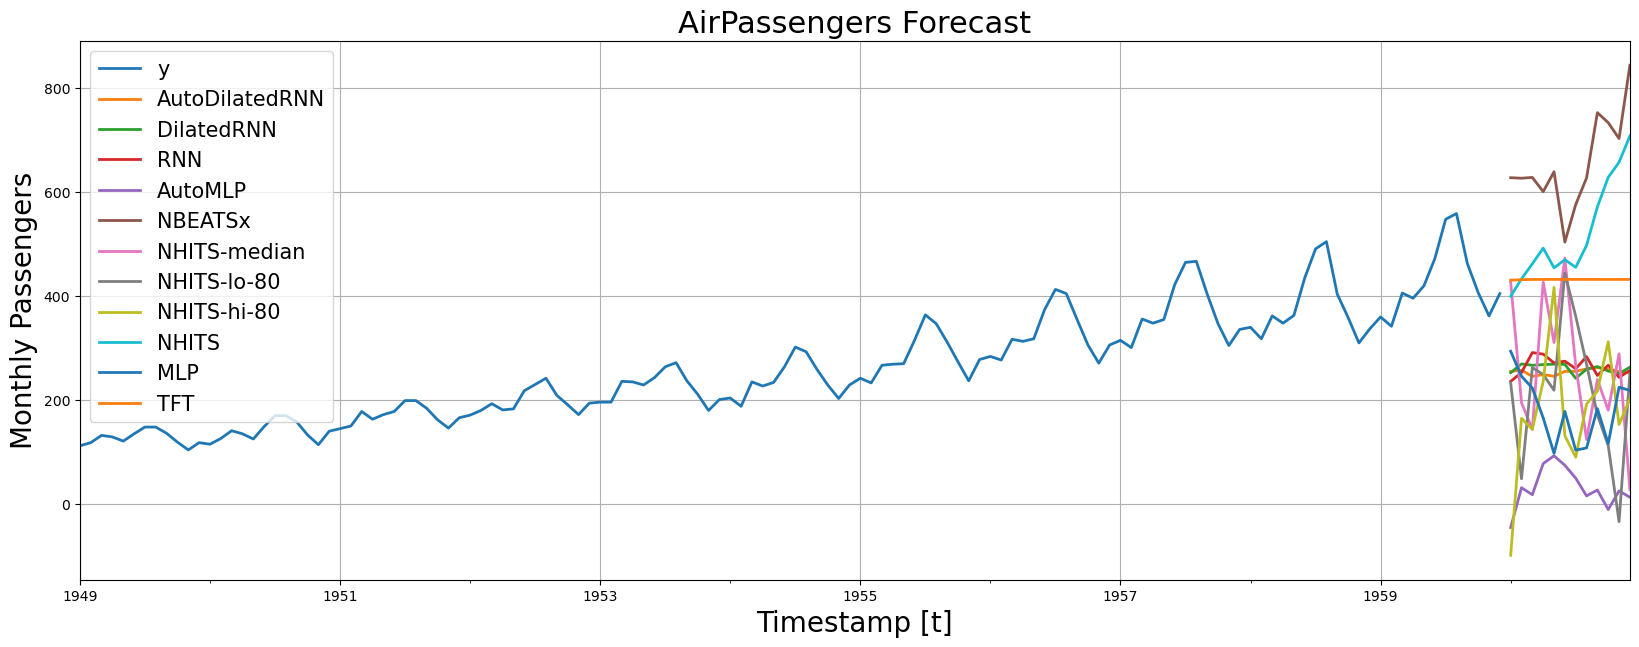

In [18]:
#| hide
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, forecasts.reset_index()]).set_index('ds')

plot_df[plot_df['unique_id']=='Airline1'].drop(['unique_id','trend','y_[lag12]'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

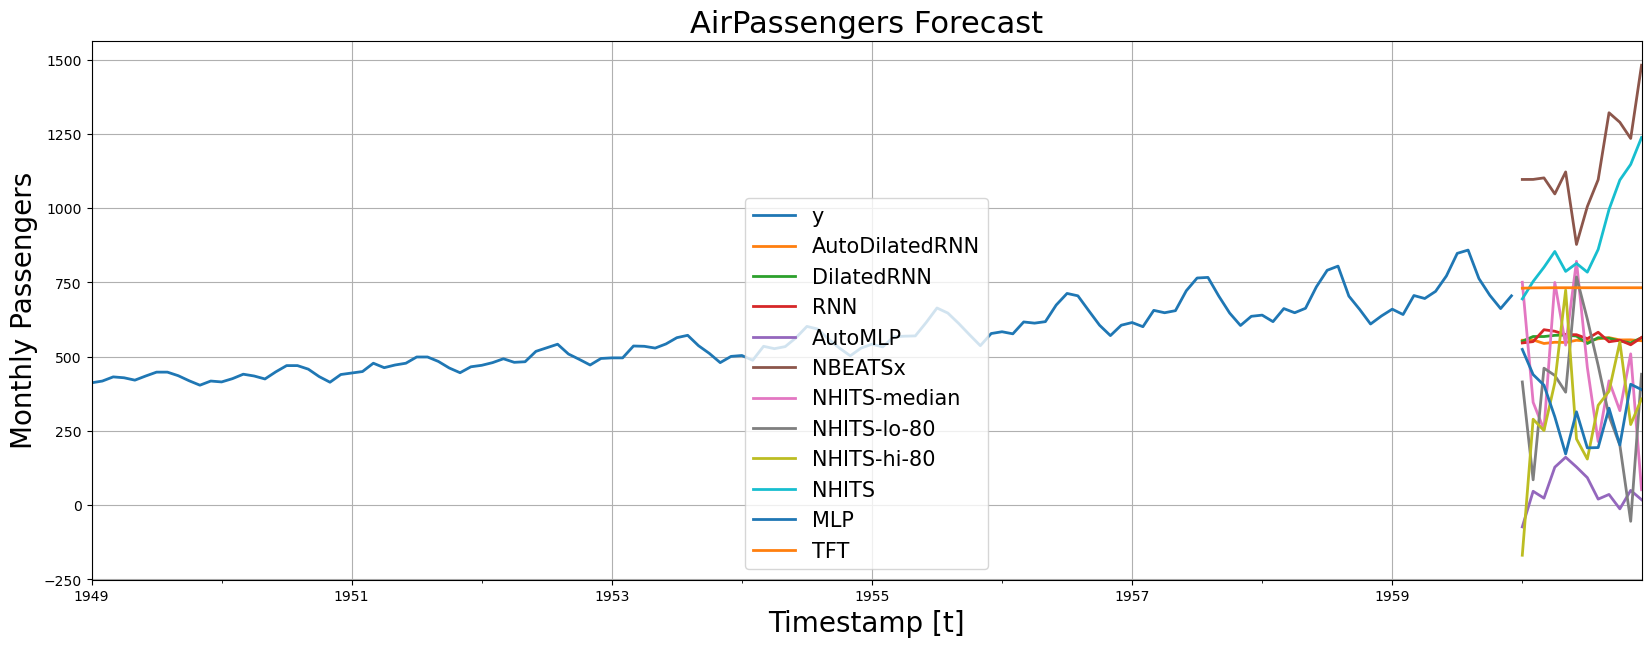

In [19]:
#| hide
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, forecasts.reset_index()]).set_index('ds')

plot_df[plot_df['unique_id']=='Airline2'].drop(['unique_id','trend','y_[lag12]'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [20]:
#| hide
fcst = NeuralForecast(
    models=[
        DilatedRNN(h=12, input_size=12,  state_hsize=50, max_epochs=10),
        AutoMLP(h=12, config=config, cpus=1, num_samples=1),
        NHITS(h=12, input_size=12, max_epochs=10)
    ],
    freq='M'
)
cv_df = fcst.cross_validation(AirPassengersPanel, n_windows=3, step_size=1)

Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=420, v_num=0, train_loss_step=420.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 13.44it/s, loss=420, v_num=0, train_loss_step=420.0, val_loss=533.0, train_loss_epoch=420.0]


(train_tune pid=10877) /opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=10877)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [21]:
#| hide
#test cross validation no leakage
def test_cross_validation(df, h, test_size):
    if (test_size - h) % 1:
        raise Exception("`test_size - h` should be module `step_size`")
    
    n_windows = int((test_size - h) / 1) + 1
    Y_test_df = df.groupby('unique_id').tail(test_size)
    Y_train_df = df.drop(Y_test_df.index)
    config = {'input_size': tune.choice([12, 24]), 'h': h, 
              'step_size': 12, 'hidden_size': 256, 'max_epochs': 1}
    config_drnn = {'input_size': tune.choice([12, 24]), 'state_hsize': tune.choice([50, 100]),
                   'h': 12, 'max_epochs': 1, 'step_size': 1}
    fcst = NeuralForecast(
        models=[
            AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=1),
            DilatedRNN(h=12, input_size=12, state_hsize=50, max_epochs=1),
            RNN(h=12, input_size=12, state_hsize=50, max_epochs=1,
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            AutoMLP(h=12, config=config, cpus=1, num_samples=1),
            MLP(h=12, input_size=12, max_epochs=1, scaler_type='robust'),
            NBEATSx(h=12, input_size=12, max_epochs=1,
                futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            NHITS(h=12, input_size=12, max_epochs=1, scaler_type='robust'),
            NHITS(h=12, input_size=12, loss=MQLoss(level=[80]), max_epochs=1),
            TFT(h=12, input_size=24, max_epochs=1, scaler_type='robust')
        ],
        freq='M'
    )
    fcst.fit(Y_train_df)
    Y_hat_df = fcst.predict(futr_df=Y_test_df)
    Y_hat_df = Y_hat_df.merge(Y_test_df, how='left', on=['unique_id', 'ds'])
    last_dates = Y_train_df.groupby('unique_id').tail(1)
    last_dates = last_dates[['unique_id', 'ds']].rename(columns={'ds': 'cutoff'})
    Y_hat_df = Y_hat_df.merge(last_dates, how='left', on='unique_id')
    
    #cross validation
    fcst = NeuralForecast(
        models=[
            AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=1),
            DilatedRNN(h=12, input_size=12, state_hsize=50, max_epochs=1),
            RNN(h=12, input_size=12, state_hsize=50, max_epochs=1,
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            AutoMLP(h=12, config=config, cpus=1, num_samples=1),
            MLP(h=12, input_size=12, max_epochs=1, scaler_type='robust'),
            NBEATSx(h=12, input_size=12, max_epochs=1,
                futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            NHITS(h=12, input_size=12, max_epochs=1, scaler_type='robust'),
            NHITS(h=12, input_size=12, loss=MQLoss(level=[80]), max_epochs=1),
            TFT(h=12, input_size=24, max_epochs=1, scaler_type='robust')
        ],
        freq='M'
    )
    Y_hat_df_cv = fcst.cross_validation(df, test_size=test_size, 
                                        n_windows=None)
    pd.testing.assert_frame_equal(
        Y_hat_df[Y_hat_df_cv.columns],
        Y_hat_df_cv,
        check_dtype=False
    )

In [22]:
#| hide
test_cross_validation(AirPassengersPanel, h=12, test_size=12)

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=431, v_num=0, train_loss_step=431.0]
(train_tune pid=11026) 
Validation: 0it [00:00, ?it/s]0m 
(train_tune pid=11026) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  9.51it/s, loss=431, v_num=0, train_loss_step=431.0, val_loss=540.0, train_loss_epoch=431.0]


(train_tune pid=11026) /opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=11026)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]